# 1.Introduction
我在数据科学领域很陌生，特别是变压器对我来说是一个非常新的概念。在我探索更多关于BERT的知识时，我注意到kaggle上的大部分材料要么讨论BERT模型中的底层逻辑和模块（这对初学者来说是必要的），要么提供没有太多细节的代码块。这份材料试图弥合从BERT模型的基础和理论到简单模型实用性的差距。

这本笔记本中的许多工作都是受这本笔记本中chumajin工作的启发。我想在这里感谢他，并补充说，我已经使其适应了我们在这次比赛中的问题。我还添加了更多的可视化，以查看模型在不同时代和不同褶皱的迭代中的影响。

## 1.1 Objective
创建一个模型，预测每个评论的每种毒性的概率。

本笔记本分为两部分。由于kaggle中的内存限制，我将其分成两部分。您可以独立运行第一部分或第二部分。

在第一部分中，我试图解释我们处理类似任务需要采取的主要步骤，对于不同标签的二分类。这部分中的模型仅适用于训练集和验证集的一个分布。你可以看到我们从这个模型中得到的初始性能结果（auc分数）。

在第二部分中，我已经从第一部分中列出了所有必要的代码块，然后展示了如何为k_fold（k=5）中的训练集和验证集的不同选择开发5个模型。然后将每个评论的所有类型毒性的概率估计为这5个模型的平均值。

## 1.2 Parameters affecting simulation time
为了快速运行这个笔记本，看看它是如何工作的，在第一部分和第二部分，您可以将训练集减少到有限的行数。我在第一部分中取了200行，在第二部分中取了2000行。

在第一部分中它非常低的原因是代码选择了教育原因而不是效率。因此，它读取了许多不同的变量，如果我们超过200行，就会导致cuda内存崩溃。这给我们第一部分的结果并不令人印象深刻（准确率86%）

在第二部分中，代码比第一部分更方便，并且可以增加行数以包含整个训练集。但是，我将其限制在2000，因此您可以在22分钟的模拟中获得相当好的结果（94%的准确率和0.988 auc分数）。

你可以有(epochs = 5, k = 5) ，看看不同纪元的精度和损耗是如何影响的。精度和损耗在可接受的范围内，因为这本笔记本不关心达到最先进的结果。

# PART 1
# 2.Prepare the data
## 2.1 Loading libraries

In [4]:
import numpy as np
import pandas as pd
import os
import random
import time

import re
import string
import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", context="talk")
plt.style.use('dark_background')

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as func
from torch.utils.data import DataLoader, Dataset

import transformers
from transformers import AdamW, get_linear_schedule_with_warmup

import tokenizers
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, auc

import warnings
warnings.simplefilter('ignore')

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# 我们为结果的可重复性播下了seed。
SEED = 34

def random_seed(SEED):
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True

random_seed(SEED)

In [7]:
train = pd.read_csv('./jigsaw-toxic-comment-classification-challenge/train.csv', nrows = 200 )
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [8]:
temp = train[train['toxic'] == 1]
temp.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0


In [9]:
# 打印了train数据集中 'comment_text' 列的第10个样本的字符总数。
print(len(train['comment_text'][10]), 'Total Characters')
# 使用 train['comment_text'][10] 来访问 train 数据集中 'comment_text' 列的第10个样本。
train['comment_text'][10]

2875 Total Characters


'"\nFair use rationale for Image:Wonju.jpg\n\nThanks for uploading Image:Wonju.jpg. I notice the image page specifies that the image is being used under fair use but there is no explanation or rationale as to why its use in Wikipedia articles constitutes fair use. In addition to the boilerplate fair use template, you must also write out on the image description page a specific explanation or rationale for why using this image in each article is consistent with fair use.\n\nPlease go to the image description page and edit it to include a fair use rationale.\n\nIf you have uploaded other fair use media, consider checking that you have specified the fair use rationale on those pages too. You can find a list of \'image\' pages you have edited by clicking on the ""my contributions"" link (it is located at the very top of any Wikipedia page when you are logged in), and then selecting ""Image"" from the dropdown box. Note that any fair use images uploaded after 4 May, 2006, and lacking such a

In [11]:
# 一条评论可以同时有毒、severe_toxic、淫秽和侮辱。所以每个评论的类别不限于一个。
# 现在让我们检查训练数据集中每一列的值。

# 从训练数据集中删除 'id' 和 'comment_text' 列，得到一个新的DataFrame对象 labels，其中包含了除了这两列之外的所有列。
labels = train.drop(['id', 'comment_text'], axis = 1)
# 定义了一个名为 unique_values 的 lambda 函数，该函数接受一个参数 x，并返回 train[x] 列的独特值。
unique_values = lambda x: train[x].unique()
# 遍历 labels DataFrame 的所有列。对于每一列，代码调用 unique_values 函数，并将结果收集到一个列表中。
[unique_values(col) for col in labels.columns.tolist()]

[array([0, 1]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1])]

In [12]:
test = pd.read_csv('./jigsaw-toxic-comment-classification-challenge/test.csv', nrows = 100)
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [13]:
test_labels = pd.read_csv('./jigsaw-toxic-comment-classification-challenge/test_labels.csv', nrows = 10)
test_labels.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [14]:
submission = pd.read_csv('./jigsaw-toxic-comment-classification-challenge/sample_submission.csv', nrows = 10)
submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5


# 2.Summerize data
## 2.1 Descriptive statistics

In [15]:
# Missing values
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [16]:
test.isnull().sum()

id              0
comment_text    0
dtype: int64

In [17]:
# 太好了！我们没有缺失的商品了！
# 训练集和测试标签中每个类的分布
# 让我们检查一下在我们的训练数据中每个类别有多少

# 从训练数据集中删除 'id' 和 'comment_text' 列，得到一个新的DataFrame对象 df_train，其中包含了除了这两列之外的所有列。
df_train = train.drop(['id', 'comment_text'], axis = 1)
# 对 df_train 的每列进行求和操作，得到每个标签的计数值。这将返回一个Series对象，其中索引是标签列的名称，值是对应列的计数值。
label_counts = df_train.sum()
# 将计数值转换为DataFrame对象，并将列名设置为 'counts'。
df_counts = pd.DataFrame(label_counts)
# 将列名 0 更改为 'counts'。
df_counts.rename(columns = {0:'counts'}, inplace = True)
# 对DataFrame对象 df_counts 按计数值从大到小进行排序。
df_counts = df_counts.sort_values('counts', ascending = False)
df_counts 

,counts
toxic,20
insult,12
obscene,11
severe_toxic,3
identity_hate,3
threat,2


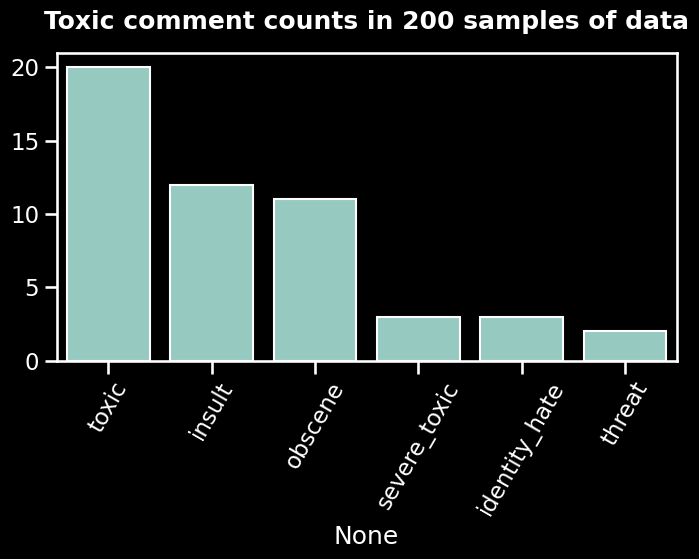

In [21]:
# 创建了一个新的图形对象 fig 和一个坐标轴对象 ax。figsize=(8, 4) 指定了图形的尺寸为宽度 8 英寸、高度 4 英寸。
fig, ax = plt.subplots(figsize = (8,4))
# 创建了一个垂直条形图。x=df_counts.index 指定了 x 轴的数据，即标签列的名称，
# y=df_counts['counts'] 指定了 y 轴的数据，即标签列的计数值。函数的返回值 p 是一个表示绘制的条形图的对象。
p = sns.barplot(x=df_counts.index, y=df_counts['counts'])
# 使用 plt.xticks() 函数旋转 x 轴刻度标签，使其以 60 度的角度显示。
x = plt.xticks(rotation = 60) 
# 设置图形的标题。标题文本由字符串 'Toxic comment counts in '、训练数据集的样本数 len(df_train) 和字符串 ' samples of data' 组成。
# weight='bold' 和 fontsize=18 设置标题的字体样式和大小，y=1.05 控制标题的垂直位置。
ax.set_title('Toxic comment counts in '+ str(len(df_train))+ ' samples of data', weight = 'bold', fontsize = 18, y = 1.05)
# 将 y 轴的标签设为空字符串，即不显示 y 轴的标签。
x = ax.set_ylabel('')

In [22]:
# 相对百分比让我们更好地理解。
labels = np.round(df_train.sum()/len(df_train)*100, 1)
labels

toxic            10.0
severe_toxic      1.5
obscene           5.5
threat            1.0
insult            6.0
identity_hate     1.5
dtype: float64